In [82]:
import geopandas as gpd
import imageio
import pandas as pd
import pathlib
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from geopandas import GeoDataFrame
from shapely.geometry import Point

## Data Preprocessing

In [3]:
census = pd.read_csv('new_york_tree_census_2015.csv')
census.head(5)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,...,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp
0,606945,305778,2016-06-28,10,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,...,25,14,QN37,Kew Gardens Hills,4125700,New York,40.724339,-73.805180,1.038250e+06,203232.9417
1,160321,341273,2015-08-19,9,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,...,34,13,QN28,Jackson Heights,4030902,New York,40.756626,-73.894167,1.013571e+06,214953.6472
2,541347,325281,2015-12-30,7,0,OnCurb,Alive,Good,Pyrus calleryana,Callery pear,...,32,10,QN76,Baisley Park,4028800,New York,40.679777,-73.788463,1.042923e+06,187008.2671
3,613930,203822,2016-07-05,10,0,OnCurb,Alive,Good,Pyrus calleryana,Callery pear,...,46,22,BK31,Bay Ridge,3005000,New York,40.622743,-74.037543,9.738279e+05,166160.5847
4,18353,338911,2015-06-13,4,0,OnCurb,Alive,Good,Prunus virginiana,'Schubert' chokecherry,...,31,10,QN12,Hammels-Arverne-Edgemere,4095400,New York,40.596514,-73.797622,1.040452e+06,156667.5017


In [7]:
census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 683788 entries, 0 to 683787
Data columns (total 41 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   tree_id     683788 non-null  int64  
 1   block_id    683788 non-null  int64  
 2   created_at  683788 non-null  object 
 3   tree_dbh    683788 non-null  int64  
 4   stump_diam  683788 non-null  int64  
 5   curb_loc    683788 non-null  object 
 6   status      683788 non-null  object 
 7   health      652172 non-null  object 
 8   spc_latin   652169 non-null  object 
 9   spc_common  652169 non-null  object 
 10  steward     652173 non-null  object 
 11  guards      652172 non-null  object 
 12  sidewalk    652172 non-null  object 
 13  user_type   683788 non-null  object 
 14  problems    652124 non-null  object 
 15  root_stone  683788 non-null  object 
 16  root_grate  683788 non-null  object 
 17  root_other  683788 non-null  object 
 18  trunk_wire  683788 non-null  object 
 19  tr

In [10]:
census = census.set_index('tree_id')

In [93]:
census.groupby('boroname').health.value_counts(normalize=True)


boroname       health
Bronx          Good      0.826494
               Fair      0.135100
               Poor      0.038407
Brooklyn       Good      0.814238
               Fair      0.147711
               Poor      0.038051
Manhattan      Good      0.758614
               Fair      0.183574
               Poor      0.057812
Queens         Good      0.815249
               Fair      0.145180
               Poor      0.039572
Staten Island  Good      0.814939
               Fair      0.143284
               Poor      0.041778
Name: health, dtype: float64

In [139]:
mh = census[census['boroname'] == 'Manhattan']

In [140]:
mh_health = mh.iloc[:,[2,3,4,5,6,7,8,9,13,14,15,16,17,18,19,20,21,22,28]]

In [141]:
mh_health.head()

,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,boroname
tree_id,,,,,,,,,,,,,,,,,,,
21173,8,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,None,TrunkOtherBranchOther,No,No,No,No,No,Yes,No,No,Yes,Manhattan
111516,2,0,OnCurb,Alive,Good,Tilia americana,American linden,None,None,No,No,No,No,No,No,No,No,No,Manhattan
365757,12,0,OnCurb,Alive,Good,Fraxinus pennsylvanica,green ash,None,None,No,No,No,No,No,No,No,No,No,Manhattan
142361,4,0,OnCurb,Alive,Good,Malus,crab apple,None,None,No,No,No,No,No,No,No,No,No,Manhattan
211906,0,6,OffsetFromCurb,Stump,NaN,NaN,NaN,NaN,NaN,No,No,No,No,No,No,No,No,No,Manhattan


<AxesSubplot:>

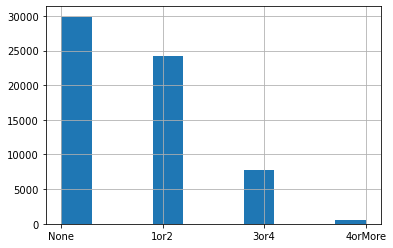

In [142]:
mh_health['steward'].hist()

<AxesSubplot:>

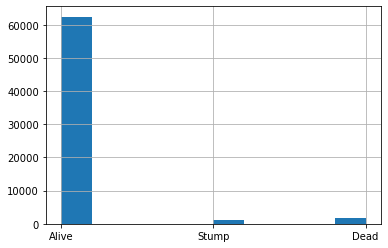

In [143]:
mh_health['status'].hist()

In [144]:
class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr))
        self.upper_bound.append(q3 + (self.factor * iqr))

    def fit(self,X,y=None):
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None):
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
            X.iloc[:, i] = x
        return X
    
outlier_remover = OutlierRemover()

array([[<AxesSubplot:title={'center':'tree_dbh'}>]], dtype=object)

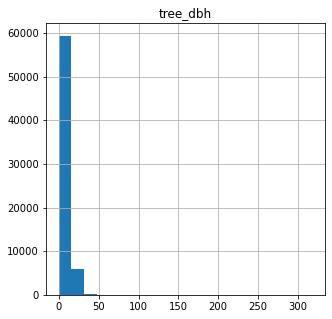

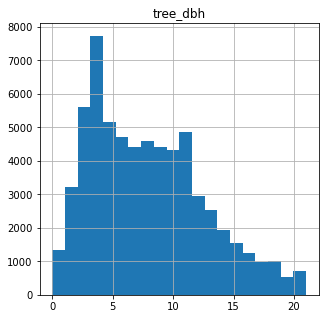

In [145]:
outlier_pre = pd.DataFrame(mh_health['tree_dbh'].copy())
outlier_pre.hist(bins=20, figsize=(5,5))
outlier_post = outlier_remover.fit_transform(outlier_pre)
outlier_post.hist(bins=20, figsize=(5,5))

<AxesSubplot:>

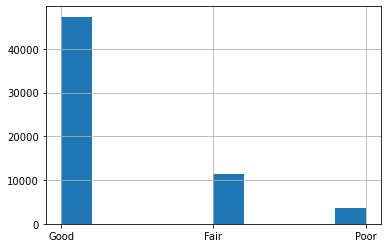

In [146]:
mh_health['health'].hist()

<AxesSubplot:xlabel='steward'>

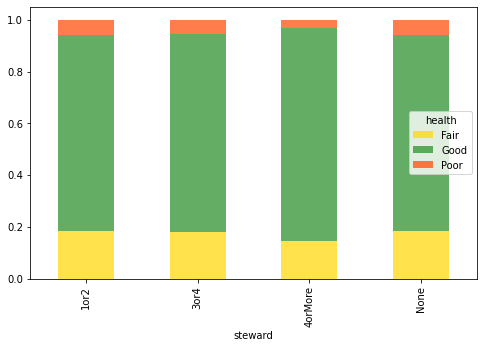

In [148]:
steward_health = mh_health.groupby('steward').health.value_counts(normalize=True).unstack()

steward_health.plot(kind='bar', stacked=True, figsize=(8,5), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

In [177]:
mh_health['spc_common'].value_counts().rename('species_counts')[:20].to_frame().reset_index()

,index,species_counts
0,honeylocust,13176
1,Callery pear,7297
2,ginkgo,5859
3,pin oak,4584
4,Sophora,4453
5,London planetree,4122
6,Japanese zelkova,3596
7,littleleaf linden,3333
8,American elm,1698
9,American linden,1583


In [149]:
mh_health.groupby(['spc_common']).health.value_counts().unstack()

health,Fair,Good,Poor
spc_common,,,
'Schubert' chokecherry,40.0,111.0,12.0
American beech,4.0,15.0,3.0
American elm,259.0,1361.0,78.0
American hophornbeam,12.0,64.0,8.0
American hornbeam,13.0,67.0,5.0
...,...,...,...
weeping willow,4.0,8.0,NaN
white ash,8.0,40.0,2.0
white oak,56.0,162.0,23.0


/var/folders/51/42w_kz156q920kx3w9jz1lwm0000gn/T/ipykernel_19999/3061626559.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  p4.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)


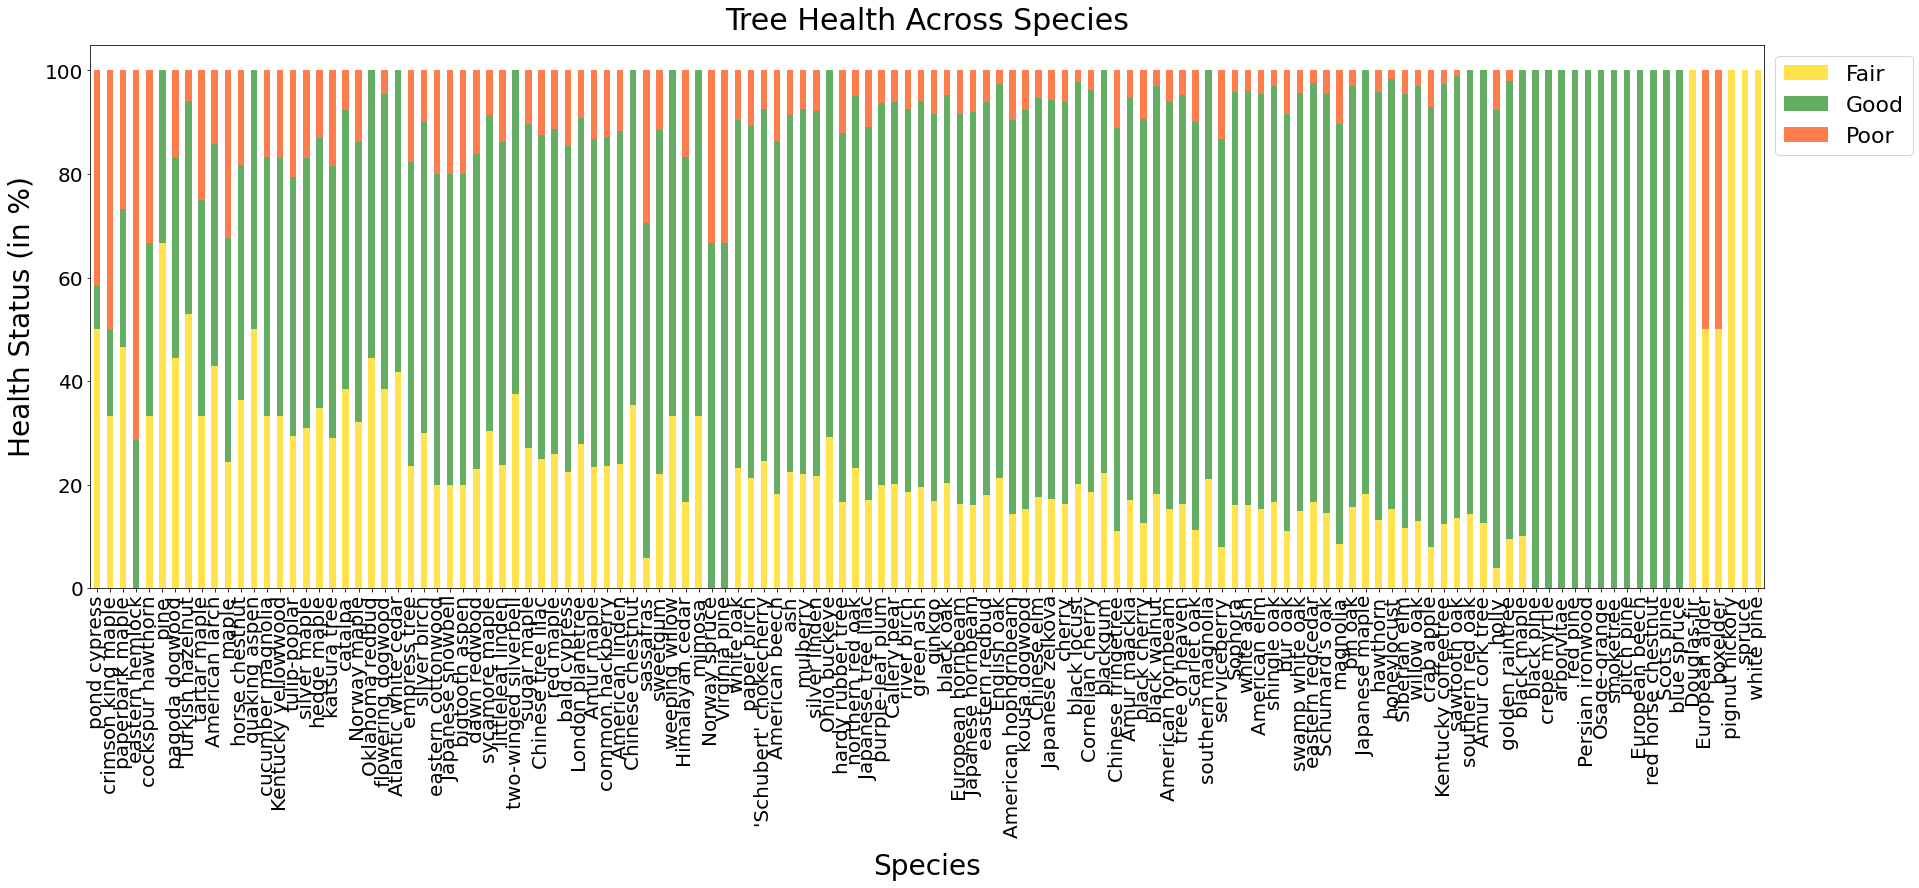

In [173]:
spc = mh_health.groupby(['spc_common']).health.value_counts(normalize=True).unstack().sort_values('Good')

# plot stacked bar graph
p4 = spc.plot(kind='bar', stacked=True, figsize=(30,10), color=['gold', 'forestgreen', 'orangered'], alpha=0.7)

# prettify the graph
p4.set_title('Tree Health Across Species', fontsize=30, pad=15)
p4.set_xlabel('Species', fontsize=28, labelpad=15)
p4.set_xticklabels(p4.get_xticklabels(), fontsize=20)
p4.set_ylabel('Health Status (in %)', fontsize=28, labelpad=10)
p4.set_yticklabels([0, 20, 40, 60, 80, 100], fontsize=20)
p4.legend(['Fair','Good', 'Poor'], bbox_to_anchor=(1,1), fontsize=22)

Narrow down to top 20 species